## Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
import json

%matplotlib inline

import re
import string

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Download Yelp Dataset from Kaggle

Create a kaggle API Token

go to kaggle.com -> account -> create new api token <p>
place kaggle.json to directory  (same path as the current notebook)

or download the dataset from
https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset or the attached files on onedrive

In [ ]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

In [ ]:
!mkdir dataset
!unzip -q yelp-dataset.zip -d dataset

## Preprocessing

In [15]:
%%time
review_file = 'dataset/yelp_academic_dataset_review.json'
business_file = 'dataset/yelp_academic_dataset_business.json'

# load json file
reviews_json = [json.loads(line) for line in open(review_file, 'r', encoding='UTF-8')]
restaurant_json = [json.loads(line) for line in open(business_file, 'r', encoding='UTF-8')]

CPU times: user 50.9 s, sys: 6.99 s, total: 57.9 s
Wall time: 2min 24s


In [16]:
# importing to pandas
reviews_df = pd.DataFrame(reviews_json)
restaurant_df = pd.DataFrame(restaurant_json)

In [17]:
restaurant_df.rename({'stars':'res_avg_stars'}, axis=1, inplace=True)

In [18]:
# remove businesss that are not restaurants (categories might be 'restaurant' or 'restaurants')
res_business_id = restaurant_df[restaurant_df['categories'].notnull() & restaurant_df['categories'].str.contains('Restaurant')]

In [20]:
# filter reviews consisting of only business of which are restaurants
merged_df = pd.merge(reviews_df, res_business_id, on='business_id', how='inner')[["business_id", "user_id", "text", "stars", "date", "city","res_avg_stars","review_count"]]

In [21]:
# counting null values
merged_df.isna().sum()

business_id      0
user_id          0
text             0
stars            0
date             0
city             0
res_avg_stars    0
review_count     0
dtype: int64

In [23]:
review_dupes_check = merged_df.groupby(['business_id','user_id']).count()['stars']

In [95]:
review_dupes_check[review_dupes_check > 1].count() # there are users who leave more than 1 review in the same restaurant

141834

In [25]:
merged_df.head()

,business_id,user_id,text,stars,date,city,res_avg_stars,review_count
0,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,"If you decide to eat here, just be aware it is...",3.0,2018-07-07 22:09:11,North Wales,3.0,169
1,XQfwVwDr-v0ZS3_CbbE5Xw,Iaee7y6zdSB3B-kRCo4z1w,This is the second time we tried turning point...,2.0,2017-05-13 17:06:55,North Wales,3.0,169
2,XQfwVwDr-v0ZS3_CbbE5Xw,ejFxLGqQcWNLdNByJlIhnQ,The place is cute and the staff was very frien...,4.0,2017-08-08 00:58:18,North Wales,3.0,169
3,XQfwVwDr-v0ZS3_CbbE5Xw,f7xa0p_1V9lx53iIGN5Sug,We came on a Saturday morning after waiting a ...,3.0,2017-11-19 02:20:23,North Wales,3.0,169
4,XQfwVwDr-v0ZS3_CbbE5Xw,dCooFVCk8M1nVaQqcfTL3Q,"Mediocre at best. The decor is very nice, and ...",2.0,2017-09-09 17:49:47,North Wales,3.0,169


Get only the latest review by user

In [26]:
latest_day_df = merged_df.groupby(["user_id", "business_id"]).agg({"date": "max"}).rename(columns={"date": "latest_day"}).reset_index()

In [27]:
latest_restaurant_df = pd.merge(merged_df, latest_day_df.rename(columns={'latest_day':'date'}), on=["user_id", "business_id", "date"], how="inner")

In [28]:
review_count = latest_restaurant_df.groupby("city").count()['business_id'].sort_values(ascending=False).to_frame().reset_index()
review_count.head()

,city,business_id
0,Philadelphia,665773
1,New Orleans,466007
2,Nashville,318578
3,Tampa,293144
4,Indianapolis,242033


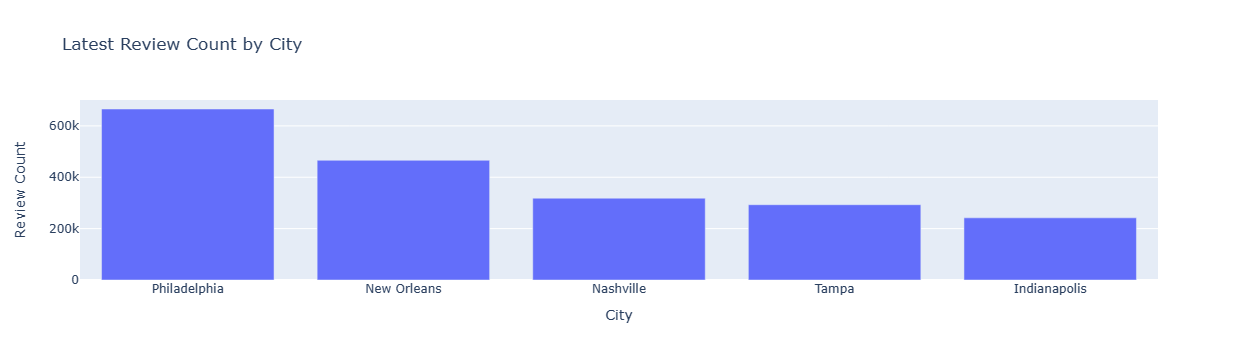

In [85]:
import plotly.express as px

fig = px.bar(review_count[0:5], x='city', y='business_id', 
             title="Latest Review Count by City", 
             labels={
                     "business_id": "Review Count",
                     "city": "City"
                 })
fig.show()

In [30]:
philly_latest_df = latest_restaurant_df[latest_restaurant_df['city'] == 'Philadelphia']
philly_latest_df.head()

,business_id,user_id,text,stars,date,city,res_avg_stars,review_count
216,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,"Wow! Yummy, different, delicious. Our favo...",5.0,2015-01-04 00:01:03,Philadelphia,4.0,181
217,kxX2SOes4o-D3ZQBkiMRfA,kSMOJwJXuEUqzfmuFncK4A,Dine-in gets 2 stars. Disappointing service & ...,2.0,2014-07-13 17:25:47,Philadelphia,4.0,181
218,kxX2SOes4o-D3ZQBkiMRfA,Z-xgVb4nM42943m2wbBkFw,We've eaten here 3 times and it seems that eac...,5.0,2017-01-02 14:25:26,Philadelphia,4.0,181
219,kxX2SOes4o-D3ZQBkiMRfA,2SEoXb6r6hPKrl9V9VzBgA,Came to Philly for a family event but stayed a...,5.0,2015-07-28 17:15:20,Philadelphia,4.0,181
220,kxX2SOes4o-D3ZQBkiMRfA,toFm0jWZJKqsOmHE7kMbRA,A very neat little hole in the wall. Very clea...,5.0,2015-06-21 01:11:14,Philadelphia,4.0,181


In [31]:
user_indexer = pd.factorize(philly_latest_df['user_id'])
business_indexer = pd.factorize(philly_latest_df['business_id'])
philly_latest_df['user_id_index'] = user_indexer[0]
philly_latest_df['business_id_index'] = business_indexer[0]

In [32]:
philly_latest_df.head()

,business_id,user_id,text,stars,date,city,res_avg_stars,review_count,user_id_index,business_id_index
216,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,"Wow! Yummy, different, delicious. Our favo...",5.0,2015-01-04 00:01:03,Philadelphia,4.0,181,0,0
217,kxX2SOes4o-D3ZQBkiMRfA,kSMOJwJXuEUqzfmuFncK4A,Dine-in gets 2 stars. Disappointing service & ...,2.0,2014-07-13 17:25:47,Philadelphia,4.0,181,1,0
218,kxX2SOes4o-D3ZQBkiMRfA,Z-xgVb4nM42943m2wbBkFw,We've eaten here 3 times and it seems that eac...,5.0,2017-01-02 14:25:26,Philadelphia,4.0,181,2,0
219,kxX2SOes4o-D3ZQBkiMRfA,2SEoXb6r6hPKrl9V9VzBgA,Came to Philly for a family event but stayed a...,5.0,2015-07-28 17:15:20,Philadelphia,4.0,181,3,0
220,kxX2SOes4o-D3ZQBkiMRfA,toFm0jWZJKqsOmHE7kMbRA,A very neat little hole in the wall. Very clea...,5.0,2015-06-21 01:11:14,Philadelphia,4.0,181,4,0


In [73]:
kk_cnt = philly_latest_df.groupby("user_id_index").agg({"business_id_index": "count"}).rename(columns={"business_id_index": "business_rated"}).reset_index()

In [ ]:
kk_cnt = kk_cnt[kk_cnt["business_rated"] >= 10] # get users who review 10 or more restaurants

In [47]:
philly_latest_df

,business_id,user_id,text,stars,date,city,res_avg_stars,review_count,user_id_index,business_id_index
216,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,"Wow! Yummy, different, delicious. Our favo...",5.0,2015-01-04 00:01:03,Philadelphia,4.0,181,0,0
217,kxX2SOes4o-D3ZQBkiMRfA,kSMOJwJXuEUqzfmuFncK4A,Dine-in gets 2 stars. Disappointing service & ...,2.0,2014-07-13 17:25:47,Philadelphia,4.0,181,1,0
218,kxX2SOes4o-D3ZQBkiMRfA,Z-xgVb4nM42943m2wbBkFw,We've eaten here 3 times and it seems that eac...,5.0,2017-01-02 14:25:26,Philadelphia,4.0,181,2,0
219,kxX2SOes4o-D3ZQBkiMRfA,2SEoXb6r6hPKrl9V9VzBgA,Came to Philly for a family event but stayed a...,5.0,2015-07-28 17:15:20,Philadelphia,4.0,181,3,0
220,kxX2SOes4o-D3ZQBkiMRfA,toFm0jWZJKqsOmHE7kMbRA,A very neat little hole in the wall. Very clea...,5.0,2015-06-21 01:11:14,Philadelphia,4.0,181,4,0
...,...,...,...,...,...,...,...,...,...,...
4561548,BEuGzy5gxtGyOEk8iwDfTg,reFwg-F-MCoRS1pA2YexMg,Very friendly people making great food at a re...,5.0,2020-08-02 00:06:32,Philadelphia,5.0,5,160817,5853
4561549,BEuGzy5gxtGyOEk8iwDfTg,dh3UhfqpFSoCitl8WCrdfw,I've had these pictures to post this review fo...,5.0,2021-03-20 07:33:23,Philadelphia,5.0,5,209516,5853
4561550,BEuGzy5gxtGyOEk8iwDfTg,nXwPLYvazD_Nd2Sar3eSWA,"Chicken stew is amazing, fresh juices are deli...",5.0,2020-11-20 06:39:38,Philadelphia,5.0,5,164226,5853
4561551,BEuGzy5gxtGyOEk8iwDfTg,MlOJCxiiB1TeZN-is2Q4SA,Doesn't look like much when you pass by but th...,5.0,2020-04-23 14:30:52,Philadelphia,5.0,5,16684,5853


In [51]:
filtered_restaurant_df = pd.merge(philly_latest_df, kk_cnt, on="user_id_index", how="inner").drop(['business_rated','city'],axis=1)

In [52]:
filtered_restaurant_df

,business_id,user_id,text,stars,date,res_avg_stars,review_count,user_id_index,business_id_index
0,kxX2SOes4o-D3ZQBkiMRfA,DVMopL-MS3_03qMW0Dxa1A,I've been here several times. The price is rea...,4.0,2014-11-13 20:50:21,4.0,181,6,0
1,AmI3LIUNwsi4023hOVGu3w,DVMopL-MS3_03qMW0Dxa1A,"The wife and I have never been to Moshulu, tho...",4.0,2017-09-26 18:16:06,3.5,874,6,1352
2,wGnBaLvgH3hrq6C3AnO5Mg,DVMopL-MS3_03qMW0Dxa1A,Since the very first time I discovered and vis...,4.0,2015-06-14 00:04:04,3.5,93,6,2081
3,fYSaoJMOj7-r4XWEuYjRxw,DVMopL-MS3_03qMW0Dxa1A,"This is SPECIFICALLY for the Afro-Beat Sunday,...",3.0,2016-07-11 13:58:52,2.5,215,6,2518
4,mXNKjKkq7Zk6-39_t4c5OA,DVMopL-MS3_03qMW0Dxa1A,After being very unwelcome at Zarafshon (see m...,3.0,2014-11-11 04:11:31,4.0,9,6,2787
...,...,...,...,...,...,...,...,...,...
294998,gu7iuTiVwyPAI_S2fwVi9Q,ZNbF8pW5CfbEhNfgs2nsUA,This is probably my favorite Chinese spot in t...,4.0,2018-01-06 14:52:54,3.5,41,152325,4885
294999,FUMp1kmo3ix5BstG-OW-8Q,ZNbF8pW5CfbEhNfgs2nsUA,We came here after leaving Leda & the Swan aro...,4.0,2020-03-31 07:03:09,4.0,23,152325,5246
295000,_7V_3b2dSSVIXqVMJwGmoQ,ZNbF8pW5CfbEhNfgs2nsUA,Ugh I have trust issues when it comes to Chine...,2.0,2020-03-31 06:43:10,3.0,57,152325,5325
295001,oynwmvwg1CUYCk0-VpZlAg,ZNbF8pW5CfbEhNfgs2nsUA,My first visit today. Absolutely love this pla...,5.0,2019-03-09 19:40:17,4.5,42,152325,5752


In [53]:
filtered_restaurant_df.to_csv('master_filtered_philly_295k.csv', index=False) #save as a 'checkpoint'

## Applying Sentiment Analysis to Text Reviews

In [54]:
df_test = pd.read_csv('master_filtered_philly_295k.csv')

In [55]:
df_test.describe()

,stars,res_avg_stars,review_count,user_id_index,business_id_index
count,295003.000000,295003.000000,295003.000000,295003.000000,295003.000000
mean,3.837927,3.820259,552.003932,15052.051833,2719.734942
std,1.122135,0.541520,740.659309,17030.846714,1695.512807
min,1.000000,1.000000,5.000000,6.000000,0.000000
25%,3.000000,3.500000,132.000000,3009.000000,1247.000000
50%,4.000000,4.000000,312.000000,9174.000000,2611.000000
75%,5.000000,4.000000,657.000000,21152.000000,4153.000000
max,5.000000,5.000000,5721.000000,152325.000000,5852.000000


In [56]:
# Create a numeric user_id and business_id column
df_test['user_id_index'] = df_test['user_id_index'].astype("category")
df_test['business_id_index'] = df_test['business_id_index'].astype("category")
df_test['user_id_cat'] = df_test['user_id_index'].cat.codes
df_test['business_id_cat'] = df_test['business_id_index'].cat.codes

df_test.head()

,business_id,user_id,text,stars,date,res_avg_stars,review_count,user_id_index,business_id_index,user_id_cat,business_id_cat
0,kxX2SOes4o-D3ZQBkiMRfA,DVMopL-MS3_03qMW0Dxa1A,I've been here several times. The price is rea...,4.0,2014-11-13 20:50:21,4.0,181,6,0,0,0
1,AmI3LIUNwsi4023hOVGu3w,DVMopL-MS3_03qMW0Dxa1A,"The wife and I have never been to Moshulu, tho...",4.0,2017-09-26 18:16:06,3.5,874,6,1352,0,1342
2,wGnBaLvgH3hrq6C3AnO5Mg,DVMopL-MS3_03qMW0Dxa1A,Since the very first time I discovered and vis...,4.0,2015-06-14 00:04:04,3.5,93,6,2081,0,2065
3,fYSaoJMOj7-r4XWEuYjRxw,DVMopL-MS3_03qMW0Dxa1A,"This is SPECIFICALLY for the Afro-Beat Sunday,...",3.0,2016-07-11 13:58:52,2.5,215,6,2518,0,2500
4,mXNKjKkq7Zk6-39_t4c5OA,DVMopL-MS3_03qMW0Dxa1A,After being very unwelcome at Zarafshon (see m...,3.0,2014-11-11 04:11:31,4.0,9,6,2787,0,2765


In [57]:
%%time

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

def nltk_prediction(text):
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    return compound_score

df_with_nltk_sent = df_test.copy()
df_with_nltk_sent['nltk_sentiment'] = df_test["text"].apply(nltk_prediction)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


CPU times: user 7min 17s, sys: 56.5 ms, total: 7min 17s
Wall time: 7min 18s


In [58]:
df_with_nltk_sent['nltk_sentiment'].to_frame().describe()

,nltk_sentiment
count,295003.000000
mean,0.763480
std,0.437067
min,-0.998200
25%,0.810800
50%,0.945800
75%,0.981700
max,0.999900


<AxesSubplot: xlabel='nltk_sentiment', ylabel='Count'>

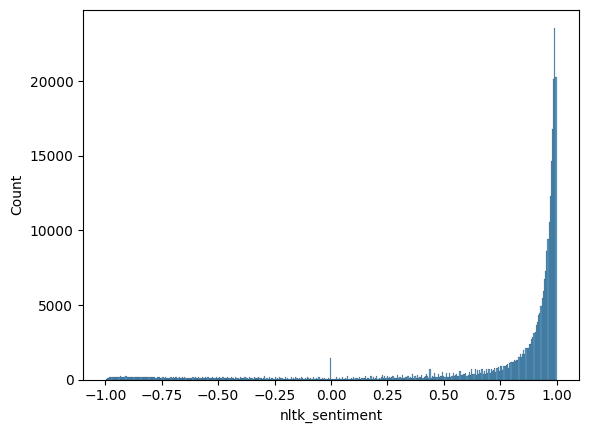

In [60]:
sns.histplot(df_with_nltk_sent['nltk_sentiment']) #histogram of ratings from vader text

<AxesSubplot: xlabel='stars', ylabel='Count'>

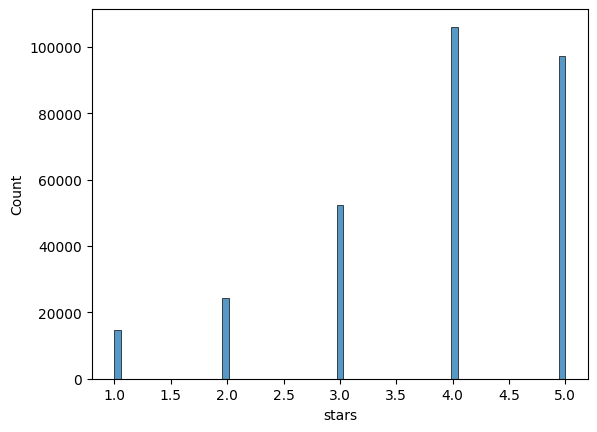

In [68]:
sns.histplot(df_with_nltk_sent['stars']) #histogram of actual ratings

In [69]:
output_df = df_with_nltk_sent.copy()

In [70]:
output_df.drop(columns=['user_id_index','business_id_index'], inplace=True)

In [71]:
output_df.head()

,business_id,user_id,text,stars,date,res_avg_stars,review_count,user_id_cat,business_id_cat,nltk_sentiment
0,kxX2SOes4o-D3ZQBkiMRfA,DVMopL-MS3_03qMW0Dxa1A,I've been here several times. The price is rea...,4.0,2014-11-13 20:50:21,4.0,181,0,0,0.9451
1,AmI3LIUNwsi4023hOVGu3w,DVMopL-MS3_03qMW0Dxa1A,"The wife and I have never been to Moshulu, tho...",4.0,2017-09-26 18:16:06,3.5,874,0,1342,0.9845
2,wGnBaLvgH3hrq6C3AnO5Mg,DVMopL-MS3_03qMW0Dxa1A,Since the very first time I discovered and vis...,4.0,2015-06-14 00:04:04,3.5,93,0,2065,0.9798
3,fYSaoJMOj7-r4XWEuYjRxw,DVMopL-MS3_03qMW0Dxa1A,"This is SPECIFICALLY for the Afro-Beat Sunday,...",3.0,2016-07-11 13:58:52,2.5,215,0,2500,0.6562
4,mXNKjKkq7Zk6-39_t4c5OA,DVMopL-MS3_03qMW0Dxa1A,After being very unwelcome at Zarafshon (see m...,3.0,2014-11-11 04:11:31,4.0,9,0,2765,0.9929


In [72]:
output_df.to_csv('vader_sent_filtered_philly_295k.csv', index=False)